## Поиск кратчайщего расстояния между двумя точками на прямой и на шаре

В данном блокноте мы хотим найти [кратчайшие кривые в выбраных метрических пространствах](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B0%D1%82%D1%87%D0%B0%D0%B9%D1%88%D0%B0%D1%8F). Для начала разберёмся с тем, как решение будет выглядеть для прямой на плоскости в декартовой системе координат:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Реализуем функцию по расчёту длины прямой.

Расстояние на плоскости вычисляется по следующей формуле:
\begin{equation}
L = \int_{t_0}^{t_1} dt \, \sqrt{\left(\frac{dx}{dt}\right)^2 + \left(\frac{dy}{dt}\right)^2}.
\end{equation}

Где $t$ параметризует кривую на плоскости.
Мы сопоставим величине $L$ дискретный функционал на сетке $x_n,\, y_n$ и будем минимизировать его.

In [ ]:
def length(x, y):
    n = len(x)
    h = 1 / (n - 1)
    delta_x = x[1:] - x[:-1]
    delta_y = y[1:] - y[:-1]
    L = np.sum(np.sqrt(delta_x ** 2 + delta_y ** 2))
    return L

In [ ]:
# Тестовые точки
test_x = np.array([1, 0, 0, 0])
test_y = np.array([1, 0, 0, 0])
length(test_x, test_y)

np.float64(1.4142135623730951)

Также мы знаем формулу для расчёта каждой точки прямой:
\begin{gather}
L = \sum_{i=0}^{n-2} \sqrt{(x_{n+1} - x_n)^2 + (y_{n+1} - y_n)^2}
\end{gather}
Для нахождения кратчайшего расстояния, нам необходимо минимизировать наш функционал. Воспользуемся алгоритмом [градиентного спуска](https://ru.wikipedia.org/wiki/%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA):
\begin{gather}
\omega_i\mapsto \omega_i-\alpha\frac{d}{d\omega_i}L(f_\omega, X, y)
\end{gather}

In [ ]:
def grad(x_arr, y_arr):
    lx_temp = []
    ly_temp = []
    N_arr = len(x_arr)

    for i in range(1, N_arr - 1):
        delta_x1 = x_arr[i] - x_arr[i + 1]
        delta_y1 = y_arr[i] - y_arr[i + 1]
        delta_x2 = x_arr[i] - x_arr[i - 1]
        delta_y2 = y_arr[i] - y_arr[i - 1]

        if delta_y1 ** 2 < 10**(-12):
            delta_y1 = 10e-12
        if delta_y2 ** 2 < 10**(-12):
            delta_y2 = 10e-12
        if delta_x1 ** 2 < 10**(-12):
            delta_x1 = 10e-12
        if delta_x2 ** 2 < 10**(-12):
            delta_x2 = 10e-12

        dlx = delta_x1 / np.sqrt(delta_x1 ** 2 + delta_y1 ** 2 + 1e-12) + delta_x2 / np.sqrt(delta_x2 ** 2 + delta_y2 ** 2 + 1e-12)
        dly = delta_y1 / np.sqrt(delta_x1 ** 2 + delta_y1 ** 2 + 1e-12) + delta_y2 / np.sqrt(delta_x2 ** 2 + delta_y2 ** 2 + 1e-12)

        lx_temp.append(dlx)
        ly_temp.append(dly)

    return np.array(lx_temp), np.array(ly_temp)

In [ ]:
def descend(x_t, y_t, alpha):
    n = len(x_t)
    lx, ly = grad(x_t, y_t)

    x_t[1: n-1] = x_t[1: n-1] - alpha*lx
    y_t[1: n-1] = y_t[1: n-1] - alpha*ly

    return x_t, y_t

In [ ]:
N = 20
# Выбираем начальные точки на плоскости
x_test = [50, 10]
y_test = [6, 98]
x = np.linspace(x_test[0], y_test[0], num = N)
y = np.linspace(x_test[1], y_test[1], num = N)

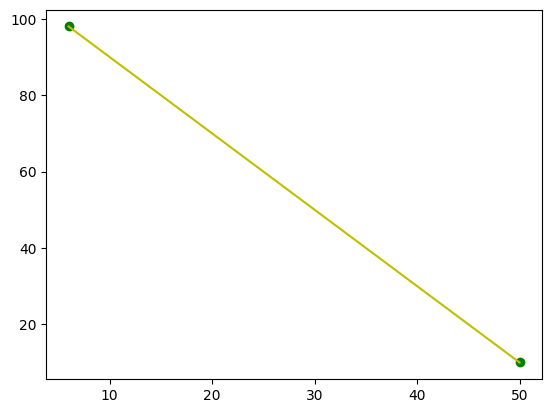

In [ ]:
# Просто рисуем
plt.plot(x, y, c='y')
plt.scatter([x_test[0], y_test[0]],[x_test[1], y_test[1]], c='g')

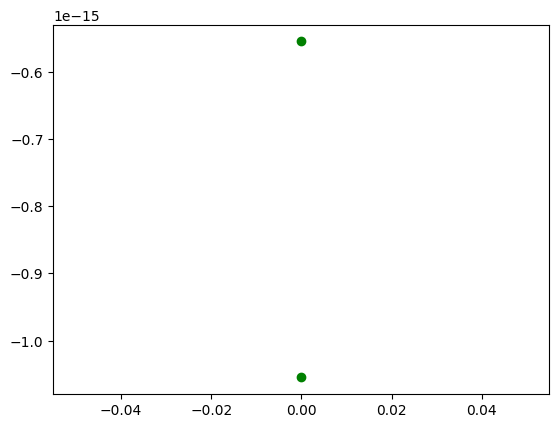

In [ ]:
# Проверяем работу корректную работу градиента
lx_train, ly_train = grad(x, y)
plt.scatter([0, 0], [lx_train[1], ly_train[1]], c = 'g')

In [ ]:
# Смотрим, как работает градиентовый спуск
x_new = np.zeros(N)
y_new = np.zeros(N)
x_new[0], x_new[-1], y_new[0], y_new[-1] = x_test[0], x_test[1], y_test[0], y_test[1]

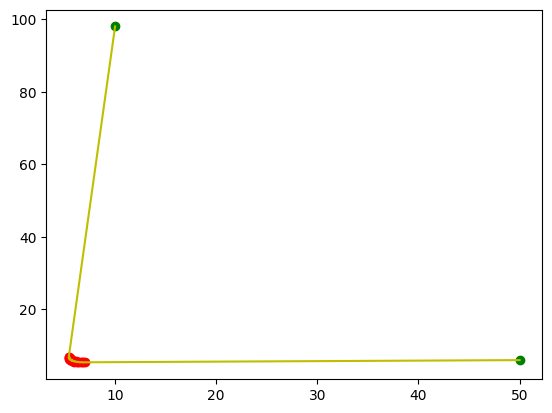

In [ ]:
for i in range(1000):
    x_new, y_new = descend(x_new, y_new, 0.1)

plt.scatter([x_new[0], x_new[-1]], [y_new[0], y_new[-1]], c='g')
plt.plot(x_new, y_new, c='y')
plt.scatter(x_new[1:-1], y_new[1:-1], c='r')

При реализации градиентового спуска столкнулись со следующей проблемой. Все точки группируются около определённого значения (выделены красным цветом). Но это никак не влияет на правильности результата работы алгоритма для поиска кратчайшего расстояние на плоскости

## Далее реализуем функции для нахождения кратчайшего расстония на сфере:

In [ ]:
# Переводим декартовы координаты х,у в полярные r,phi
def to_polar_coord(x_temp, y_temp):
    r_temp = np.sqrt(x_temp ** 2 + y_temp ** 2)
    for value in x_temp:
        if (abs(value)<10e-10):
            print("Division by zero!")
            value = 10e-10
    phi_temp = np.arctan(y_temp / x_temp)
    return r_temp, phi_temp

In [ ]:
# Переводим в полярные r,phi в декартовы координаты х,у
def to_decart_coord(r_temp, phi_temp, R):
    x_temp = r_temp * np.cos(phi_temp)
    y_temp = r_temp * np.sin(phi_temp)

    zR = np.ones(N)*R
    z_temp = np.sqrt(zR**2 - r_temp**2)

    return x_temp, y_temp, z_temp

In [ ]:
# Выбираем начальные точки в пространстве
N = 12
R = 10.

r = 0.5*R*np.ones(N) + 0.01*R*(np.ones(N)-2*np.random.rand(N))
r[0] = 0.5*R
r[-1] = r[0]
phi = np.linspace(0., np.pi/2, num = N) + 0.01*np.pi*(np.ones(N)-2*np.random.rand(N))
phi[0] = 0
phi[-1] = np.pi/2

Выведем на экран первоначальное положение точек

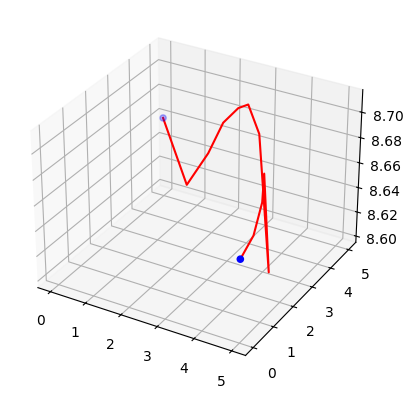

In [ ]:
x_polar, y_polar, z = to_decart_coord(r, phi, R)

ax = plt.figure().add_subplot(projection='3d')
ax.plot(x_polar, y_polar, z, c ='r')
ax.scatter([x_polar[0], x_polar[-1]], [y_polar[0], y_polar[-1]], [z[0], z[-1]], c = 'b')

In [ ]:
# Считаем элемент длины между узлами i,i+1
def length_elem(i, r, phi, rad):
    # Отдельно считаем знаменатель
    if (( 1-(r[i+1]+r[i])/2./rad) < 10e-7):
        print("Large!")
        denom = 2.*10e-7
    else :
        denom = 1.-(r[i+1]+r[i])**2/4./rad**2
    return np.sqrt((r[i+1]-r[i])**2/denom+(r[i+1]+r[i])**2/4.*(phi[i+1]-phi[i])**2)

In [ ]:
# Вычисляем дискретизованную версию длины
def length(r, phi, rad):
    l = 0.0
    for i in range(len(r)-1):
        l += length_elem(i, r, phi, rad)
    return l

Реализуем градиентный спуск для функции расчёта каждой точки кривой на сфере:
\begin{equation}
L = \sum_{i=0}^{n-2} \sqrt{\frac{(r_{i+1} - r_i)^2}{1-\frac{(r_{i+1} + r_i)^2}{4R^2}} + \frac{(r_{i+1} + r_i)^2}{4}(\phi_{i+1}-\phi_i)^2}
\end{equation}
Этот функционал также построен из непрерывного аналога. Мы поместили сферу в объемлющее 3-хмерное пространство с координатами $x, y, z$. Полярные координаты $r, \phi$ задают проекцию точки на плоскость $x,y$. Координата $z$ в получается из уравнения сферы $z^2 + r^2 = R^2$.


Также, в отличие от реализации на плоскости, мы должны учесть проблему с локальными минимумами градиента. Для этого добавим штрафной элемент и проверку на смещение точек:
- для первого находим средние расстояние между элементами (avg_dist), после подгоняем под него остальные интервалы.
- для второго вводим параметр максимального отклоения (max_shift), далее благодаря нему не даём системе сильно изменяться

In [ ]:
def grad_polar(r, phi, n, rad, avg_dist): # avg_dist
    lr_temp = []
    lphi_temp = []

    for i in range(1, n-1):
        # Для i+1,i
        # Отдельно считаем знаменатель
        if (( 1.-(r[i+1]+r[i])/2./rad) < 10e-7):
            denom_ip1 = 2.*10e-7
        else :
            denom_ip1 = 1.-(r[i+1]+r[i])**2/4./rad**2
        # Приращение r и phi
        delta_r_ip1 = r[i] - r[i+1]
        delta_phi_ip1 = phi[i] - phi[i+1]
        # На случай, если элемент длины слишком мал
        if (length_elem(i,r,phi,rad) < 10e-7):
            l_ip1 = 10e-7
        else :
            l_ip1 = length_elem(i,r,phi,rad)

        # Для i-1,i
        # Отдельно считаем знаменатель
        if (( 1.-(r[i-1]+r[i])/2./rad) < 10e-7):
            denom_im1 = 2.*10e-7
        else :
            denom_im1 = 1.-(r[i-1]+r[i])**2/4./rad**2
        # Приращение r и phi
        delta_r_im1 = r[i] - r[i-1]
        delta_phi_im1 = phi[i] - phi[i-1]
        # На случай, если элемент длины слишком мал
        if (length_elem(i-1,r,phi,rad) < 10e-7):
            l_im1 = 10e-7
        else :
            l_im1 = length_elem(i-1,r,phi,rad)
        # Градиент от r[i]
        dl_dr = (delta_r_ip1/denom_ip1**2*(1.-r[i+1]*(r[i+1]+r[i])/2./rad**2)+(r[i+1]+r[i])/4.*delta_phi_ip1**2)/l_ip1 \
            +(delta_r_im1/denom_im1**2*(1.-r[i-1]*(r[i-1]+r[i])/2./rad**2)+(r[i-1]+r[i])/4.*delta_phi_im1**2)/l_im1

        # Градиент от phi[i]
        dl_dphi = delta_phi_ip1*(r[i+1]+r[i])**2/4./l_ip1+delta_phi_im1*(r[i-1]+r[i])**2/4./l_im1

        # Добавляем штрафной термин
        dist_ip1 = np.sqrt(delta_r_ip1**2 + delta_phi_ip1**2)
        dist_im1 = np.sqrt(delta_r_im1**2 + delta_phi_im1**2)
        dl_dr += 2 * (dist_ip1 - avg_dist) * delta_r_ip1 / dist_ip1
        dl_dr += 2 * (dist_im1 - avg_dist) * delta_r_im1 / dist_im1
        dl_dphi += 2 * (dist_ip1 - avg_dist) * delta_phi_ip1 / dist_ip1
        dl_dphi += 2 * (dist_im1 - avg_dist) * delta_phi_im1 / dist_im1

        lr_temp.append(dl_dr)
        lphi_temp.append(dl_dphi)

    return np.array(lr_temp), np.array(lphi_temp)

In [ ]:
def descend_polar(r, phi, alpha, n, rad, max_shift):

    distances = np.zeros(n-2)
    for i in range(1, n-1):
        dist = np.sqrt((r[i+1] - r[i])**2 + (phi[i+1] - phi[i])**2)
        distances[i-1] = dist
    avg_dist = distances.mean()

    # Считаем градиент
    lr_des, lphi_des = grad_polar(r, phi, n, rad, avg_dist) # avg_dist
    # Т.к. r ограничен 0 и rad, подкручиваем alpha так, чтобы не вылететь за пределы допустимых значений
    max_grad = lr_des.max()
    min_grad = lr_des.min()
    min_deriv = abs(r[1: n-1]-rad*np.ones(n-2)).min()
    min_r = r[1: n-1].min()
    if (alpha*max_grad > min_r):
        alpha = min_r/max_grad
    if (-alpha*min_grad > min_deriv) :
        alpha = -min_deriv/min_grad

    # Добавляем проверку максимального смещения
    max_shift_r = max_shift * np.ones(n-2)
    max_shift_phi = max_shift * np.ones(n-2)
    if (alpha * np.abs(lr_des) > max_shift_r).any():
        alpha = max_shift_r / np.abs(lr_des)
        alpha = alpha.min()
    if (alpha * np.abs(lphi_des) > max_shift_phi).any():
        alpha = max_shift_phi / np.abs(lphi_des)
        alpha = alpha.min()

    # Шаг градиентного спуска
    r[1: n-1] = r[1: n-1] - alpha*lr_des
    phi[1: n-1] = phi[1: n-1] - alpha*lphi_des
    return r, phi


In [ ]:
# Применяем градиентовый спуск к первоначальным значениям
max_shift = 0.01
for i in range(1000):
    alpha = 0.1
    r, phi = descend_polar(r, phi, alpha, N, R, max_shift)
    for i in range(len(r)-2):
        if (r[i+1] > R) :
            print("Incorrect value! r is too large")
            r[i+1] = "NaN"
        if (r[i+1] < 0.0) :
            print("Incorrect value! r is less than 0")
            r[i+1] = "NaN"

In [ ]:
r

array([5.        , 4.73431223, 4.47058708, 4.22085466, 3.99009458,
       3.81760447, 3.81760264, 3.9900915 , 4.22085173, 4.47058545,
       4.7343109 , 5.        ])

In [ ]:
phi

array([0.        , 0.08241475, 0.17069964, 0.29017572, 0.4403993 ,
       0.65154728, 0.91924536, 1.13039486, 1.28061986, 1.40009568,
       1.48838234, 1.57079633])

In [ ]:
length(r, phi, R)

np.float64(7.236572172287261)

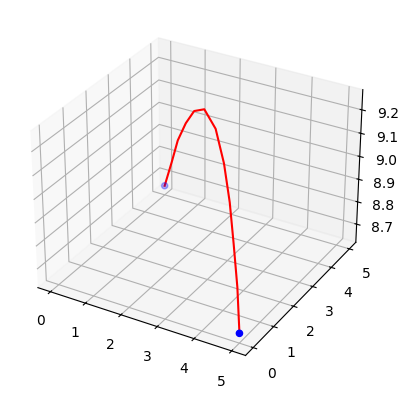

In [ ]:
# Выводим на экран первоначальное положение точек
x_polar, y_polar, z = to_decart_coord(r, phi, R)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter([x_polar[0], x_polar[-1]], [y_polar[0], y_polar[-1]], [z[0], z[-1]], c = 'b')
ax.plot(x_polar, y_polar, z, 'r')

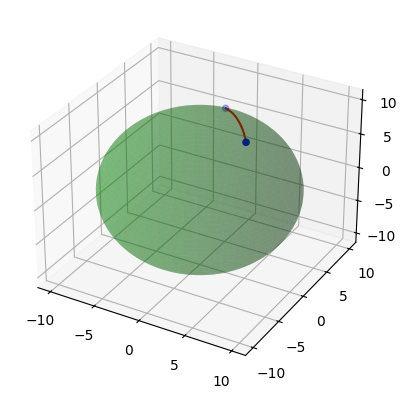

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Добавляем шар
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = R * np.outer(np.cos(u), np.sin(v))
y = R * np.outer(np.sin(u), np.sin(v))
z = R * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='g', alpha=0.3)

# Добавляем кривую
x_polar, y_polar, z = to_decart_coord(r, phi, R)
x_polar = x_polar.flatten()
y_polar = y_polar.flatten()
z = z.flatten()
ax.plot(x_polar, y_polar, z, 'r')
ax.scatter([x_polar[0], x_polar[-1]], [y_polar[0], y_polar[-1]], [z[0], z[-1]], c = 'b')

Как видно из графиков, у нас получилось найти кратчайшее расстония на сфере, используя алгоритм градиентного спуска. Синим цветом отмечены точки, между которыми искали расстояние, красным же сама кривая.